This notebook contains code to create the MPIW graphs of a model while training and graphs the quantile probabilities during training for a random sample

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from numpy import trapz
import copy 
import warnings

warnings.filterwarnings("ignore", category=UserWarning) # Prevents Tanh warning messages 

Scaler = StandardScaler()

In [2]:
def create_xy(dataset, attribute_columns, target_column, delim, split_ratio, threshold, ditch_head=False):
    with open(dataset, 'r') as f:
        lines = f.readlines()
    if ditch_head:
        lines = lines[1:]
    X = []
    Y = []
    for line in lines:
        while len(line) > 0 and line[-1] == "\n":
            line = line[:len(line)-1]
        split_array = line.split(delim)
        all_columns = []
        for value in split_array:
            if value !="" and value !=" ":
                all_columns.append(value)
        if len(all_columns)==0:
            break
        point = []
        for i in attribute_columns:
            point.append(float(all_columns[i]))
        try:
            Y.append(float(all_columns[target_column]))
            X.append(point)
        except:
            pass
    X_arr = np.asarray(X)
    Scaler.fit(X_arr)
    X_arr = Scaler.transform(X_arr)
    Y_arr = np.asarray(Y)
    thresh = np.median(Y_arr)
    Y_arr_binary = np.where(Y_arr<=threshold,0,1)
    unique, counts = np.unique(Y_arr_binary, return_counts=True)
    x_train, x_test, y_train, y_test = train_test_split(X_arr, Y_arr_binary, test_size = split_ratio)
    return x_train, x_test, y_train, y_test, Y_arr, X_arr, threshold, Y_arr_binary


In [3]:
torch.manual_seed(111)
class Network(nn.Module):
    def __init__(self, indim):
        super(Network,self).__init__()
        self.l1 = nn.Linear(indim,100)
        self.l2 = nn.Linear(100,10)
        self.l3 = nn.Linear(10,9)
        
    def forward(self,x):
        x = F.leaky_relu(self.l1(x))
        x = F.leaky_relu(self.l2(x))
        x = self.l3(x)
        return x

In [4]:
# Loss and Accuracy Computation functions

def cumLaplaceDistribution(y_pred,mean,standard_deviation,all_qs):
    term1 = ((1-all_qs) * (y_pred - mean))/standard_deviation
    term1.clamp_(max = 0) # Prevents NaN - Only one of term 1 or 2 is used, whichever is -ve
    lesser_term = all_qs * torch.exp(term1)
    term2 = (-1.0 * all_qs * (y_pred - mean))/standard_deviation
    term2.clamp_(max = 0) # Again, Prevents NaN
    greater_term = 1 - ((1-all_qs) * torch.exp(term2))
    mean_tensor = torch.ones_like(mean)
    y_mask = torch.div(y_pred,mean_tensor)
    y_mask[y_pred >= mean] = 1.0
    y_mask[y_pred < mean] = 0.0
    return ((1 - y_mask) * lesser_term )+  (y_mask * greater_term)


def logLikelihoodLoss(y_true,y_pred,mean,standard_deviation,all_qs):
    new_pred = y_pred
    prob = cumLaplaceDistribution(0.0,mean = new_pred,
                                  standard_deviation = standard_deviation,all_qs = all_qs)
    prob.clamp_(min = 1e-7,max = 1 - 1e-7)
    if_one = y_true * torch.log(1 - prob)
    if_zero = (1 - y_true) * torch.log(prob)
    final_loss = - 1 * torch.mean(if_one + if_zero)
    return final_loss

def customLoss(y_true, y_pred, mean, standard_deviation, all_qs, penalty):
    ind_losses = []
    for i,j in enumerate(all_qs):
        single_quantile_loss = logLikelihoodLoss(y_true[:,0],y_pred[:,i] ,
                                                 mean, standard_deviation, j)
        ind_losses.append(single_quantile_loss)
    zero = torch.Tensor([0]).to(device)
    dummy1 = y_pred[:,1:] - y_pred[:,:-1]
    dummy2 = penalty * torch.mean(torch.max(zero,-1.0 * dummy1))
    total_loss  = torch.mean(torch.stack(ind_losses)) +dummy2
    return total_loss

def customTestPred(y_pred,mean,standard_deviation,all_qs,batch_size = 1):
    acc = []
    cdfs = []
    val = (y_pred - mean)/standard_deviation 
    
    for xx in range(batch_size):
        if(y_pred < mean[xx]):
            lesser_term = all_qs * torch.exp((1.0 - all_qs) * torch.tensor(val[xx], dtype=torch.double)) 
            # Typecast above needed for some versions of torch
            lesser_term  = 1 - lesser_term
            cdfs.append(lesser_term.item())
            if(lesser_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
        
        elif(y_pred >= mean[xx]):
            greater_term = 1.0 - ((1.0-all_qs) * torch.exp(-1.0 * all_qs * torch.tensor(val[xx], dtype=torch.double)))
            # Typecast above needed for some versions of torch
            greater_term = 1 - greater_term
            cdfs.append(greater_term.item())
            if(greater_term.item() >= 0.5):
                acc.append([1])
            else:
                acc.append([0])
    return torch.Tensor(acc).to(device).reshape(-1,1),torch.Tensor(cdfs).to(device).reshape(-1,1)

def acc_tests(test_preds,test_labels):
    test_preds = np.array(test_preds).reshape(-1,1)
    test_labels = np.array(test_labels).reshape(-1,1)
    cdfs_acc,_ = customTestPred(0,test_preds,standard_deviation = 1,all_qs = torch.Tensor([0.5]),
                                batch_size = test_preds.shape[0])

    count = 0
    for i,j in zip(cdfs_acc,test_labels):
        if(i.item() == j[0]):
            count += 1
    return count/test_labels.shape[0]

In [5]:
# Training and Testing Methods

def train(model,optimizer, loader,epochs, verbose=False):
    train_preds_Q = []
    train_labels = []
    model.train()
    
    for i,j in enumerate(loader):
        inputs,labels = j[0],j[1]
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        op_qs = model(inputs)
        lossQ = customLoss(labels.reshape(-1,1),op_qs, mean_is,std_is,all_qs,penalty)
        lossQ.backward()
        optimizer.step()
        
        for lag in op_qs[:,4].detach().reshape(-1,1):
            train_preds_Q.append(lag.item())
        for lag in labels.reshape(-1,1):
            train_labels.append(lag.item())
            
    acc_is_Q = acc_tests(train_preds_Q,train_labels)
    
    if verbose:
        print("[%d/%d] Train Acc Q : %f "%(epochs+1,total_epochs,acc_is_Q))
    return acc_is_Q

def test(model,optimizer, loader,epochs,verbose=False):
    model.eval()
    test_preds_Q = []
    test_preds_bce = []
    test_labels = []
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            
            for lag in op_qs[:,4].detach().reshape(-1,1):
                test_preds_Q.append(lag.item())
            for lag in labels.reshape(-1,1):
                test_labels.append(lag.item())
                
    acc_is_Q = acc_tests(test_preds_Q,test_labels)
    
    if verbose:
        print("[%d/%d] Test Acc Q : %f  "%(epochs+1,total_epochs,acc_is_Q))
    return acc_is_Q

In [6]:
def quantileCDF(x, tau):
    if x>0:
        return 1 - tau*np.exp((tau-1)*x)
    else:
        return (1 - tau)*np.exp(tau*x)

def problist(model, batch_no, sample_no, loader):
    p_list = []
    with torch.no_grad():
        for i,j in enumerate(loader):
            if i== batch_no:
                inputs,labels = j[0],j[1]
                inputs = inputs.to(device)
                labels = labels.to(device)
                op_qs = model(inputs)
                for q in range(9):
                    quant_pred = op_qs[:,q].detach().reshape(-1,1)
                    sample_pred = quant_pred[sample_no].cpu()
                    p_list.append(quantileCDF(sample_pred,0.5 ).item())
    return p_list

In [7]:
def get_mpiw_array(model, loader):
    delta_arr = [0,0,0,0,0]
    total_samples = 0
    with torch.no_grad():
        for i,j in enumerate(loader):
            inputs,labels = j[0],j[1]
            inputs = inputs.to(device)
            labels = labels.to(device)
            op_qs = model(inputs)
            qv = []
            for q in range(9):
                qv.append(op_qs[:,q].detach().reshape(-1,1))
            batch_size = len(qv[0])
            total_samples += batch_size
            for c in range(batch_size):
                p_pred = quantileCDF(qv[4][c].cpu(),0.5 ).item()
                true_class = labels[c].item()
                if (p_pred < 0.5 and true_class == 0) or (p_pred >=0.5 and true_class == 1):
                    correct = 1
                else:
                    correct = 0
                for d in range(0,5):
                    q_low = qv[4-d][c].cpu()
                    p_low = quantileCDF(q_low,0.5 ).item()
                    q_high = qv[4+d][c].cpu()
                    p_high = quantileCDF(q_high,0.5 ).item()
                    if (p_low <=0.5 and p_high >=0.5):
                        delta_arr[d] += (p_high-p_low)
        delta_arr.append(total_samples) # MPIW for delta=0.5 is defined as 1
        for i in range(6):
            delta_arr[i] = delta_arr[i]/total_samples
    return delta_arr

In [8]:
batch_is = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.deterministic=True
print("Torch Device:",device)
torch.set_default_dtype(torch.double)

Torch Device: cpu


In [9]:
dataset = '../Datasets/Regression/california.csv'
x_cols = list(range(9))
y_col = 9
separator = ","
remove_head = False
mv = 180000
split_ratio = 0.2

In [10]:
X_train,X_val,y_train,y_val, data_Y, data_X, threshval, all_classes = create_xy(dataset, x_cols, y_col, 
                                                                                separator, split_ratio, mv, remove_head)
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)
X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [11]:
indim = X_train.shape[1]
model = Network(indim)
model = model.to(device)

In [12]:
train_dataset = data_utils.TensorDataset(X_train, y_train)
test_dataset = data_utils.TensorDataset(X_val, y_val)
train_loader = data_utils.DataLoader(train_dataset, batch_size =batch_is, pin_memory=True,shuffle=True,num_workers = 1)
test_loader = data_utils.DataLoader(test_dataset,batch_size =batch_is,pin_memory=True,shuffle = False,num_workers = 1)

In [13]:
lr_is = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr = lr_is)
all_qs = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
all_qs = torch.Tensor(all_qs).to(device)
mean_is = 0
std_is = 1
penalty = 1
alpha = 0.0
verbosity = False

# Control Parameters for the sample probability graph
batch_of_sample = 1
sample_no = 0

total_epochs = 10

In [14]:
mpiw_arrays = []
sample_probs = []

for i in range(total_epochs):
    acc_train = train(model,optimizer, train_loader,i, verbosity)
    sample_probs.append(problist(model, 1, 0, train_loader))
    acc_test = test(model,optimizer, test_loader,i, verbosity)
    mpiw = get_mpiw_array(model, test_loader)
    mpiw_arrays.append(mpiw)

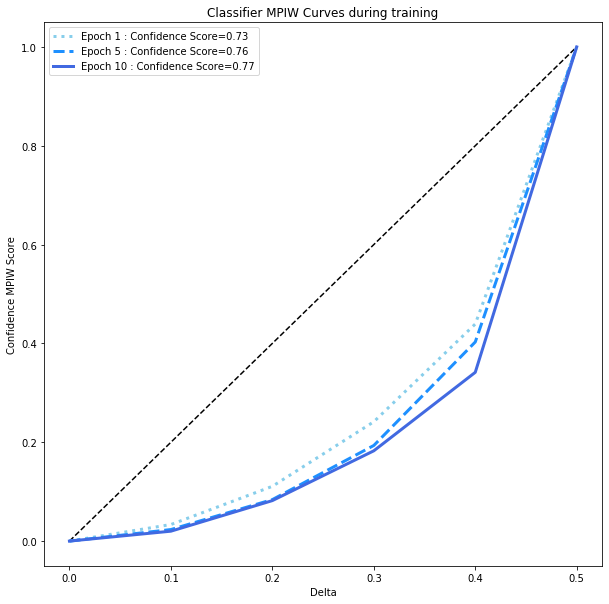

In [15]:
epochs_to_compare = [0,4,9]
conf_scores = []
for i in range(len(epochs_to_compare)):
    conf_scores.append(trapz(mpiw_arrays[epochs_to_compare[i]], dx=0.1))

x_axis=[0,0.1,0.2,0.3,0.4,0.5]
baseline = [0,0.2,0.4,0.6,0.8,1]
plt.figure(figsize=(10,10))
lbl_txt = "Epoch {0} : Confidence Score={oc:.2f}"
plt.plot(x_axis, baseline, linestyle="dashed", color="k")
plt.plot(x_axis, mpiw_arrays[0], color="skyblue",label=lbl_txt.format(1, oc= 2*(0.5-conf_scores[0])), linewidth=3, linestyle="dotted")
plt.plot(x_axis, mpiw_arrays[4], color="dodgerblue", label=lbl_txt.format(5, oc= 2*(0.5-conf_scores[1])), linewidth=3, linestyle="dashed")
plt.plot(x_axis, mpiw_arrays[9], color="royalblue", label=lbl_txt.format(10, oc= 2*(0.5-conf_scores[2])), linewidth=3)
plt.title("Classifier MPIW Curves during training")
plt.ylabel("Confidence MPIW Score")
plt.xlabel("Delta")
plt.legend()
plt.show()

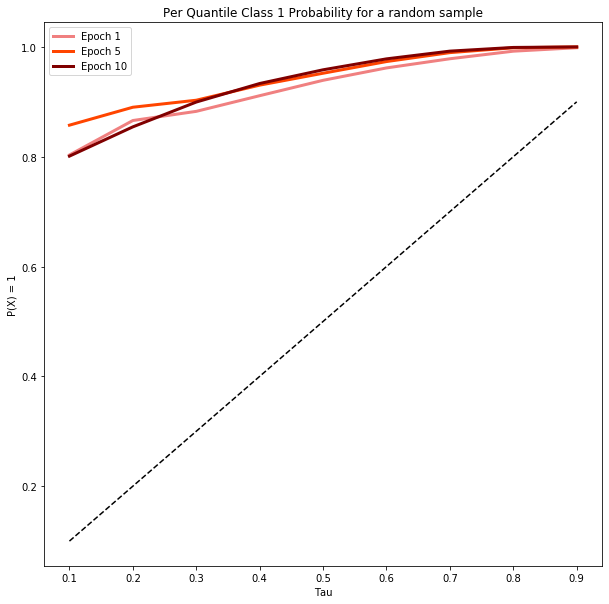

In [16]:
x_axis=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
plt.figure(figsize=(10,10))
plt.plot(x_axis, x_axis, linestyle="dashed", color="k")
plt.plot(x_axis, sample_probs[0], color="lightcoral",label="Epoch 1", linewidth=3 )
plt.plot(x_axis, sample_probs[4], color="orangered", label="Epoch 5", linewidth=3)
plt.plot(x_axis, sample_probs[9], color="maroon", label="Epoch 10", linewidth=3)
plt.title("Per Quantile Class 1 Probability for a random sample")
plt.ylabel("P(X) = 1")
plt.xlabel("Tau")
plt.legend()
plt.show()